In [ ]:
import os
import json
import flywheel
from pathlib import Path
from IPython.display import display, Markdown
from dag_objects.utils import (
    render_suggested_gear_rules, 
    render_graph_template,
    )
from helpers.gear_launching import launch_gear_and_wait
from helpers.gear_rule_util import disable_associated_project_rules

from dag_objects.graphs import DagGraphs

In [ ]:
api_key = os.environ['FW_API_KEY']
client = flywheel.Client(api_key)
# Group ID not Group Label
group_id = "includerc"
# Project Label
project_label = "processing"
project = client.lookup(f"{group_id}/{project_label}")

### 1. Define the Graph

The graph is of the [graphviz](https://graphviz.org/) format. It is a directed graph with nodes and edges. The nodes are the tasks and the edges are the dependencies between the tasks.

The start node is identified by a "S" and the end node is identified by an "E". The start node has no dependencies and the end node has no dependents.


In [3]:
graph_source = """
//DAG Demo
digraph G {
S [label="dicom-qc"]
a [label="dcm2niix"]
b [label="file-metadata-importer"]
c [label="file-classifier"]
d [label="mriqc"]
e [label="pydeface"]
f [label="nifti2dicom"]
E [label="Done"]
S->a
a->b
b->c
c->d
c->e
d->e
e->f
c->E
d->E
f->E
}
"""

### 2. Create Rules

The rules are for directed edges and the node that they are pointing to. The rule is used to define the edge conditions which the node (task) is ready to run.

Rules having the identifier in the name of `[[a->b]]` where `a` is the node that the edge is pointing from and `b` is the node that the edge is pointing to.

When all of the required edge-conditions are met for any particular node, the node executes the task.

dicom-qc: [[S]]
dcm2niix: [[S->a]]
file-metadata-importer: [[a->b]]
file-classifier: [[b->c]]
mriqc: [[c->d]]
pydeface: [[c->e]]
pydeface: [[d->e]]
nifti2dicom: [[e->f]]


[Edit Gear Rules](https://latest.sse.flywheel.io/#/projects/6520aed1279d3aa16b8e0137/gearRules)

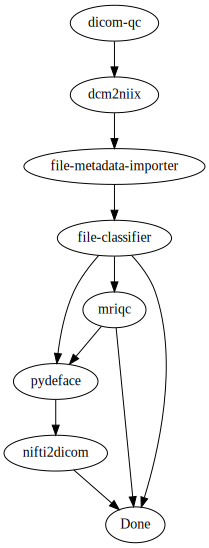

In [4]:
rule_names, dot = render_suggested_gear_rules(graph_source)

# Suggested rule names:
for rule_name in rule_names:
    print(rule_name)

md=Markdown(f"[Edit Gear Rules](https://latest.sse.flywheel.io/#/projects/{project.id}/gearRules)")
display(md)
dot

### 3. Create the DAG specification from the Gear Rules


In [5]:
# The End Edge Conditions are the rules that will be applied to the end of the graph
# This can also be created in the UI by creating a gear rule that will never run a job.
end_edge_conditions={
    "c->E": {
        "_not": [
             {
                "type": "file.classification",
                "value": "(T1|T2|T2*|Functional|FLAIR)",
                "regex": True
              }
             ]
    },
    "d->E": {
        "all": [
              {
                "type": "file.classification",
                "value": "(Functional)",
                "regex": True
              }
            ]
        },
    "f->E": {
        "all": [
              {
                "type": "file.type",
                "value": "nifti",
                "regex": False
              }
            ],
    }
}
graph_template = render_graph_template(client, project, dot, end_edge_conditions)
json.dump(graph_template, open("./graph_template.json","w"), indent=4)

### 4. Run a Gear that will Trigger the Start Node


In [ ]:
# Load the graph template from a file 
graph_template_path = Path("./graph_template.json")
graph_template = json.load(graph_template_path.open())

# Disable gear rules that will be run by the DAG
disabled_rules = disable_associated_project_rules(
    client, project, graph_template, True
)

In [ ]:
# specify the gear to use
gear_spec ={
    "name": "hierarchy-curator",
    "version": "2.1.6"
}

curator_file = project.get_file("map_include_global_id.py")
mapping_csv = project.get_file("include_global_id_mappings.csv")
input_files = {
    "additional-input-one": mapping_csv,
    "curator": curator_file,
}
config = {}

trigger_job = launch_gear_and_wait(
    client, gear_spec, input_files, config, project, wait_for_state="running", priority=None
)


In [ ]:
# We can cheat here and use the job id from the previous run

trigger_job = client.get_job("6520b148279d3aa16b8e026a")
triggered_jobs_after = trigger_job.created.strftime("%Y-%m-%dT%H:%M:%S")

### 5. Run the DAG


In [7]:
graphs = DagGraphs(client, graph_template, triggered_jobs_after, project)

In [ ]:
frame = 0
dot = graphs.draw_graphs()
while graphs.complete() == False:
    dot = graphs.update_graphs()